**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

How to partially freeze resnet34:
https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, J, H, W)

Each j in J represents a joint

**Important:** The image is of size (N, 3, H, W)

In [161]:
# Loading our own functions
import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def printGradientMaxMin(grad, name):
    print(name, "'s grad => max value: ", torch.max(grad), " min value: ", torch.min(grad));

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()

# define heatmap guassian size
g_heatmap_size = 9

def makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size):
    # heatmap 0 based, should we have a very small number instead of 0?
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    heatmap = torch.zeros(batch_size, num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1) 
    # size (N, 21, 224 + 8, 224 + 8)
    # Hao: Took me a while, but eventually figured out a way to do 4D indexing
    b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
    j_idx = torch.from_numpy( np.array(list(np.arange(num_joints))*batch_size) ).long()
    h_idx = pos2d_list[:, :, 1].view(-1).long()
    w_idx = pos2d_list[:, :, 0].view(-1).long()
    
    one_hot[b_idx, j_idx, h_idx, w_idx] = 1.0
    
    padding = int((g_heatmap_size - 1)/2)
    
    # still need some loops, but at least we only need a double loop, yeahhh, I guess
    for dh in range(-4, 5):
        for dw in range(-4, 5):
            cur_h_idx = h_idx + dh + padding
            cur_w_idx = w_idx + dw + padding
            cur_h_idx = cur_h_idx.long()
            cur_w_idx = cur_w_idx.long()
            heatmap[b_idx, j_idx, cur_h_idx, cur_w_idx] = math.exp(-1.0 * (dw**2 + dh**2))
            #loc_map_x[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 0].view(-1).float()
            #loc_map_y[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 1].view(-1).float()
            #loc_map_z[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 2].view(-1).float()
            
    heatmap = heatmap[:, :, padding:-padding, padding:-padding]
    
    return heatmap, one_hot
    
def makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # this is a quadruple loop for now, can we possibly verctorize it?
    # Change: make locmaps take on constant value through out spatial dimension
    # for example, loc_map_x(b=0, j=0, h=:, w=:) should take on the x value of joint 0 in sample 0
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x += pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y += pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z += pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    heatmap, one_hot = makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size)       

    #loc_map = torch.cat((loc_map_x[:, :, padding:-padding, padding:-padding], loc_map_y[:, :, padding:-padding, padding:-padding], loc_map_z[:, :, padding:-padding, padding:-padding]), dim=1)
    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

def makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x = loc_map_x + pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y = loc_map_y + pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z = loc_map_z + pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            # guassian-like heatmap
                            heatmap[b, i, int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
                            #1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            #loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            #loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            #loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    
    return loc_map, heatmap, one_hot

# define some constants
num_joints = 21
image_size = 224
dtype = torch.float32
epsilon = 1e-8
transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

**Load data:**

In [180]:
import time
batch_size = 8

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 100 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    print(pos3d_list[0, 0])
    
    start_time = time.time()
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("loc_map", loc_map.size())
    print("heatmap", heatmap.size())
    print("one_hot", one_hot.size())
    print("vectorized: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    loc_map_n, heatmap_n, one_hot_n = makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("naive: --- %s seconds ---" % (time.time() - start_time))
    
    print("Check the difference between vectorized impl and naive impl:")
    print("Error:", torch.sum(loc_map - loc_map_n))
    print("Error:", torch.sum(heatmap - heatmap_n))
    print("Error:", torch.sum(one_hot - one_hot_n))
    
    #print(heatmap.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([8, 3, 224, 224])
0 torch.Size([8, 21, 2])
0 torch.Size([8, 21, 3])
tensor([  43.6957,   21.5230,  367.3360], dtype=torch.float64)
loc_map torch.Size([8, 63, 224, 224])
heatmap torch.Size([8, 21, 224, 224])
one_hot torch.Size([8, 21, 224, 224])
vectorized: --- 0.09773802757263184 seconds ---
naive: --- 0.42685794830322266 seconds ---
Check the difference between vectorized impl and naive impl:
Error: tensor(0.)
Error: tensor(0.)
Error: tensor(0.)


**Build the model:**

1) Define some constants

In [181]:
# bone length bias, this is a learnable parameter!
# blb = torch.zeros(22, dtype=torch.float, requires_grad=True)
# bone length weights
blw = torch.zeros(22, 21, dtype=torch.float)
bone_list=[(0, 2), (2, 3), (3, 1), (4, 6), (6, 7), (7, 5), 
           (12, 14), (14, 15), (15, 13), (8, 10), (10, 11), 
           (11, 9), (1, 5), (5, 13), (13, 9), (16, 18), (18, 19), (19, 17), (1, 17), (5, 17), (9, 17), (13, 17)]

for idx, b in enumerate(bone_list):
    blw[idx, b[0]] = 1.0
    blw[idx, b[1]] = -1.0

#print(blw)

blw = blw.transpose(0, 1)
loss_scale = 1.0 / (batch_size * num_joints * g_heatmap_size**2 * 3)

testM = torch.randn(4, 21)

pres = torch.matmul(testM, blw)

print("Inspect a value: ", pres[0, 10])
print("Error: ", pres[0, 10] - (testM[0, 10] - testM[0, 11]))

Inspect a value:  tensor(-1.4268)
Error:  tensor(0.)


2) Define the model

In [182]:
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()

# resnet 34 has 0-9, which is 10 immediate children modules, we are discarding the last 2, so 0-7
# and let's only freeze 0-4

'''
# Here we are freezing all layers of resnet 34, which probably isn't a great idea, we know that pretrained resnet learns
# a lot of information irrelevant to our task, such as what kind of dogs are in the images
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False
'''
for num, child in enumerate(resnet34.children()):
    # freeze the lower layers only
    #print(num)
    if num < 4:
        for param in child.parameters():
            param.requires_grad = False
            
            
# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# finally, the joint prediction Convolutional Layer, filter size 3 x 3, 21 filters
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=32, out_channels=21, kernel_size=3, stride=1, padding=1)

# layers to generate the heatmap
conv6h = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)

# layers to generate the location maps
conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)

# what if we try to squash 21 heatmaps into one map, why would we need to predict a location map for each joint?
# We should predict a location map for each of x, y, z once per image
locationPrediction = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=7, stride=1, padding=3)

# stick a bunch of ReLu non-linearity in the upsampling pipeline
model = nn.Sequential(
    *list(resnet34.children())[:-3],
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
)

modelHeatmap = nn.Sequential(
    conv6h,
    nn.ReLU(),
    jointPrediction
)

modelLocmap = nn.Sequential(
    conv6,
    nn.ReLU(),
    conv7,
    nn.ReLU(),
    locationPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU


3) Define the loss function

In [183]:
def computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size):
    # TODO: how to combine l_loss and h_loss is about hyper-parameter tuning
    
    hmap_pred = nn.functional.softmax(h_pred.view(batch_size, num_joints, -1), dim=2)
    h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, num_joints, -1), dim=2)
    h_loss = 1.0 * torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
    #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size
    
    '''
    Hao: construct a combined heatmap of both the ground truth and our predicted heatmap
    since the fact that joints exist at a certain point should offer clue to what its 3D position might be
    '''
    p2d_y, p2d_x = np.unravel_index(torch.argmax(hmap_pred.view(batch_size * num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d_y = p2d_y.reshape((batch_size, num_joints))
    p2d_x = p2d_x.reshape((batch_size, num_joints))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)
    
    hp, one_hot_pred = makeHeatMapOneHot(torch.from_numpy(p2d), batch_size, num_joints, image_size)
    
    # total heatmap
    t_heatmap = hp + heatmap
    t_heatmap = t_heatmap.repeat(1, 3, 1, 1) # shape(N, 63, 224, 224)
    
    l_pred = torch.cat((l_pred[:, 0:1, :, :].expand(-1, 21, -1, -1), 
                        l_pred[:, 1:2, :, :].expand(-1, 21, -1, -1), 
                        l_pred[:, 2:3, :, :].expand(-1, 21, -1, -1)), dim=1)
    l_loss = torch.sum(torch.pow(t_heatmap * (l_pred - loc_map), 2)) * loss_scale * 0.0025
    #l_loss = l_loss**0.5
    
    # Skeleton (bone length) constraint
    # get a weighted average of predicted joint coordinates
    #coord_p = torch.sum(torch.sum(t_heatmap * l_pred, dim=3), dim=2)
    coord_p = torch.sum(torch.sum(one_hot_pred.repeat(1, 3, 1, 1) * l_pred, dim=3), dim=2)
    x_p = coord_p[:, 0:21]
    y_p = coord_p[:, 21:42]
    z_p = coord_p[:, 42:63]
    
    #x_p.register_hook(lambda grad: printGradientMaxMin(grad, 'x_p'))
    #y_p.register_hook(lambda grad: printGradientMaxMin(grad, 'y_p'))
    #z_p.register_hook(lambda grad: printGradientMaxMin(grad, 'z_p'))
    
    # GT bone length
    blb = (torch.matmul(loc_map[:, 0:num_joints, 0, 0], blw)**2 + torch.matmul(loc_map[:, num_joints:2*num_joints, 0, 0], blw)**2 + torch.matmul(loc_map[:, 2*num_joints:3*num_joints, 0, 0], blw)**2)
    
    # predicted bone length, using predicted joint 2D location as filter, rather than GT 2D joint location
    bl_x = torch.matmul(x_p, blw)**2
    bl_y = torch.matmul(y_p, blw)**2
    bl_z = torch.matmul(z_p, blw)**2
    
    #bl_x.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_x'))
    #bl_y.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_y'))
    #bl_z.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_z'))
    
    # add epsilon for numerical stability, since sqrt(x)'s derivative is 0.5/sqrt(x)
    bone_diff = torch.sqrt(bl_x + bl_y + bl_z + epsilon) - torch.sqrt(blb + epsilon)
    
    #bone_diff.register_hook(lambda grad: printGradientMaxMin(grad, 'bone_diff'))
    
    bl_loss = torch.sum(bone_diff.abs()) * 0.00025
    
    #bl_loss.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_loss'))
    
    print("h_loss: ", h_loss, " l_loss: ", l_loss, " bl_loss: ", bl_loss)
    
    loss = l_loss + h_loss + bl_loss
    return loss

**Training the model and evaluate on eval dataset:**

In [184]:
# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(modelHeatmap.parameters()) + list(modelLocmap.parameters()) ), lr=1.0e-3)
losses = []

In [186]:
for epoch in range(50):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
        # y_pred is of size 64 x 224 x 224
        y_pred = model(image)
        
        # h_pred is of size 21 x 224 x 224
        h_pred = modelHeatmap(y_pred)
        
        # l_pred is of size 3 x 224 x 224, the 3 representing x, y, z location maps of all 21 joints
        l_pred = modelLocmap(y_pred)
        
        # register a hook so I can print out its gradient
        #l_pred.register_hook(lambda grad: printGradientMaxMin(grad, 'l_pred'))
        
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
        
        # print and store the loss curve
        print("Loss: {}".format(loss))
        losses.append(loss)
        
        loss.backward()
        
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
print("======Training Done======")

Epoch: 0
h_loss:  tensor(2.8014)  l_loss:  tensor(0.3289)  bl_loss:  tensor(0.7355)
Loss: 3.865727424621582
h_loss:  tensor(2.5882)  l_loss:  tensor(0.3344)  bl_loss:  tensor(0.6796)
Loss: 3.6021242141723633
h_loss:  tensor(2.9736)  l_loss:  tensor(0.3910)  bl_loss:  tensor(0.9445)
Loss: 4.309190273284912
h_loss:  tensor(2.6542)  l_loss:  tensor(0.3428)  bl_loss:  tensor(0.7089)
Loss: 3.7058358192443848
h_loss:  tensor(3.3926)  l_loss:  tensor(0.4707)  bl_loss:  tensor(0.8086)
Loss: 4.671949863433838
h_loss:  tensor(2.7023)  l_loss:  tensor(0.2877)  bl_loss:  tensor(0.7211)
Loss: 3.7110373973846436
h_loss:  tensor(3.1275)  l_loss:  tensor(0.2880)  bl_loss:  tensor(0.8150)
Loss: 4.230522632598877
h_loss:  tensor(3.0845)  l_loss:  tensor(0.6378)  bl_loss:  tensor(0.8788)
Loss: 4.601088523864746
h_loss:  tensor(3.2801)  l_loss:  tensor(0.3802)  bl_loss:  tensor(0.7382)
Loss: 4.398519039154053
h_loss:  tensor(2.7660)  l_loss:  tensor(0.7313)  bl_loss:  tensor(0.7627)
Loss: 4.25996351242065

h_loss:  tensor(1.1917)  l_loss:  tensor(0.3087)  bl_loss:  tensor(0.5109)
Loss: 2.0113143920898438
h_loss:  tensor(1.5525)  l_loss:  tensor(0.3872)  bl_loss:  tensor(0.4599)
Loss: 2.3996336460113525
h_loss:  tensor(1.1777)  l_loss:  tensor(0.3776)  bl_loss:  tensor(0.6081)
Loss: 2.163381576538086
h_loss:  tensor(1.4753)  l_loss:  tensor(0.4407)  bl_loss:  tensor(0.5523)
Loss: 2.4683802127838135
h_loss:  tensor(1.4445)  l_loss:  tensor(0.6287)  bl_loss:  tensor(0.5769)
Loss: 2.6501307487487793
h_loss:  tensor(1.3390)  l_loss:  tensor(0.3643)  bl_loss:  tensor(0.4845)
Loss: 2.187822103500366
h_loss:  tensor(1.2050)  l_loss:  tensor(0.3978)  bl_loss:  tensor(0.5761)
Loss: 2.1789255142211914
h_loss:  tensor(1.7247)  l_loss:  tensor(0.4117)  bl_loss:  tensor(0.6661)
Loss: 2.802532911300659
Epoch: 9
h_loss:  tensor(1.0722)  l_loss:  tensor(0.4080)  bl_loss:  tensor(0.6178)
Loss: 2.098005771636963
h_loss:  tensor(1.0421)  l_loss:  tensor(0.3454)  bl_loss:  tensor(0.4507)
Loss: 1.838178515434

h_loss:  tensor(0.7075)  l_loss:  tensor(0.6370)  bl_loss:  tensor(0.3232)
Loss: 1.6677151918411255
h_loss:  tensor(0.5115)  l_loss:  tensor(0.3544)  bl_loss:  tensor(0.4576)
Loss: 1.3235573768615723
h_loss:  tensor(0.5773)  l_loss:  tensor(0.5506)  bl_loss:  tensor(0.5129)
Loss: 1.6407954692840576
h_loss:  tensor(0.8224)  l_loss:  tensor(0.4790)  bl_loss:  tensor(0.3748)
Loss: 1.6762036085128784
h_loss:  tensor(1.2614)  l_loss:  tensor(0.5239)  bl_loss:  tensor(0.5210)
Loss: 2.306312084197998
h_loss:  tensor(0.7084)  l_loss:  tensor(0.4358)  bl_loss:  tensor(0.4588)
Loss: 1.6029869318008423
Epoch: 17
h_loss:  tensor(0.3852)  l_loss:  tensor(0.4687)  bl_loss:  tensor(0.3247)
Loss: 1.1785398721694946
h_loss:  tensor(0.4468)  l_loss:  tensor(0.5020)  bl_loss:  tensor(0.4108)
Loss: 1.3596030473709106
h_loss:  tensor(0.5884)  l_loss:  tensor(0.3121)  bl_loss:  tensor(0.4676)
Loss: 1.367995262145996
h_loss:  tensor(0.8578)  l_loss:  tensor(0.3834)  bl_loss:  tensor(0.4971)
Loss: 1.738306879

h_loss:  tensor(0.2138)  l_loss:  tensor(0.3276)  bl_loss:  tensor(0.3328)
Loss: 0.8742254376411438
h_loss:  tensor(0.3119)  l_loss:  tensor(0.4261)  bl_loss:  tensor(0.3681)
Loss: 1.1060607433319092
h_loss:  tensor(0.5871)  l_loss:  tensor(0.3419)  bl_loss:  tensor(0.3843)
Loss: 1.3132388591766357
h_loss:  tensor(0.6941)  l_loss:  tensor(0.3009)  bl_loss:  tensor(0.3683)
Loss: 1.3632845878601074
Epoch: 25
h_loss:  tensor(0.5081)  l_loss:  tensor(0.3234)  bl_loss:  tensor(0.2648)
Loss: 1.096325397491455
h_loss:  tensor(0.3984)  l_loss:  tensor(0.3097)  bl_loss:  tensor(0.3111)
Loss: 1.0191855430603027
h_loss:  tensor(0.5146)  l_loss:  tensor(0.3224)  bl_loss:  tensor(0.3076)
Loss: 1.1445996761322021
h_loss:  tensor(0.3300)  l_loss:  tensor(0.2905)  bl_loss:  tensor(0.2998)
Loss: 0.9203625321388245
h_loss:  tensor(0.3485)  l_loss:  tensor(0.3538)  bl_loss:  tensor(0.2755)
Loss: 0.9777296781539917
h_loss:  tensor(0.3592)  l_loss:  tensor(0.3878)  bl_loss:  tensor(0.2712)
Loss: 1.01826202

h_loss:  tensor(0.1329)  l_loss:  tensor(0.5685)  bl_loss:  tensor(0.3373)
Loss: 1.0387182235717773
h_loss:  tensor(0.1231)  l_loss:  tensor(0.3636)  bl_loss:  tensor(0.3031)
Loss: 0.7897747755050659
Epoch: 33
h_loss:  tensor(1.00000e-02 *
       7.5934)  l_loss:  tensor(0.7274)  bl_loss:  tensor(0.4091)
Loss: 1.2123887538909912
h_loss:  tensor(0.1840)  l_loss:  tensor(0.4932)  bl_loss:  tensor(0.2794)
Loss: 0.9565669298171997
h_loss:  tensor(1.00000e-02 *
       5.8918)  l_loss:  tensor(1.0618)  bl_loss:  tensor(0.3648)
Loss: 1.485510230064392
h_loss:  tensor(0.1287)  l_loss:  tensor(0.4160)  bl_loss:  tensor(0.4044)
Loss: 0.9490686655044556
h_loss:  tensor(0.1099)  l_loss:  tensor(0.6331)  bl_loss:  tensor(0.3063)
Loss: 1.0493024587631226
h_loss:  tensor(0.1485)  l_loss:  tensor(0.6568)  bl_loss:  tensor(0.3292)
Loss: 1.1345099210739136
h_loss:  tensor(0.2007)  l_loss:  tensor(0.3259)  bl_loss:  tensor(0.3029)
Loss: 0.8295472264289856
h_loss:  tensor(0.2216)  l_loss:  tensor(0.6197) 

h_loss:  tensor(1.00000e-02 *
       4.2385)  l_loss:  tensor(0.2635)  bl_loss:  tensor(0.1891)
Loss: 0.49503105878829956
h_loss:  tensor(1.00000e-02 *
       4.6695)  l_loss:  tensor(0.2636)  bl_loss:  tensor(0.1989)
Loss: 0.5092430114746094
h_loss:  tensor(0.1063)  l_loss:  tensor(0.3290)  bl_loss:  tensor(0.2592)
Loss: 0.6944611072540283
h_loss:  tensor(1.00000e-02 *
       7.3964)  l_loss:  tensor(0.2794)  bl_loss:  tensor(0.2211)
Loss: 0.5744531154632568
h_loss:  tensor(1.00000e-02 *
       3.5158)  l_loss:  tensor(0.3181)  bl_loss:  tensor(0.2258)
Loss: 0.5790082812309265
h_loss:  tensor(1.00000e-02 *
       4.3124)  l_loss:  tensor(0.3115)  bl_loss:  tensor(0.2608)
Loss: 0.615388035774231
h_loss:  tensor(1.00000e-02 *
       6.8843)  l_loss:  tensor(0.3482)  bl_loss:  tensor(0.2847)
Loss: 0.70169597864151
h_loss:  tensor(0.2454)  l_loss:  tensor(0.2878)  bl_loss:  tensor(0.2224)
Loss: 0.7556749582290649
Epoch: 41
h_loss:  tensor(1.00000e-02 *
       3.5099)  l_loss:  tensor(0.31

h_loss:  tensor(1.00000e-02 *
       4.4751)  l_loss:  tensor(0.7106)  bl_loss:  tensor(0.3929)
Loss: 1.1482129096984863
h_loss:  tensor(1.00000e-02 *
       4.3664)  l_loss:  tensor(0.6108)  bl_loss:  tensor(0.3310)
Loss: 0.985485851764679
h_loss:  tensor(1.00000e-02 *
       7.6011)  l_loss:  tensor(0.3918)  bl_loss:  tensor(0.4124)
Loss: 0.8801393508911133
h_loss:  tensor(1.00000e-02 *
       6.9542)  l_loss:  tensor(0.5109)  bl_loss:  tensor(0.5689)
Loss: 1.149395227432251
h_loss:  tensor(1.00000e-02 *
       5.0695)  l_loss:  tensor(0.3602)  bl_loss:  tensor(0.2813)
Loss: 0.6922468543052673
h_loss:  tensor(1.00000e-02 *
       3.0454)  l_loss:  tensor(0.2916)  bl_loss:  tensor(0.3543)
Loss: 0.6764151453971863
h_loss:  tensor(1.00000e-02 *
       3.9091)  l_loss:  tensor(0.3043)  bl_loss:  tensor(0.3329)
Loss: 0.676289439201355
h_loss:  tensor(1.00000e-02 *
       4.0015)  l_loss:  tensor(0.3276)  bl_loss:  tensor(0.2656)
Loss: 0.633213996887207
h_loss:  tensor(1.00000e-02 *
      

In [138]:
#print(blb)

tensor([ 0.2317,  0.4489,  0.4188,  0.2204,  0.4444,  0.3142,  0.2163,
         0.3220,  0.3628,  0.3556,  0.2432,  0.2229,  0.2412,  0.2467,
         0.2446,  0.2208,  0.5066,  0.3610,  0.4612])


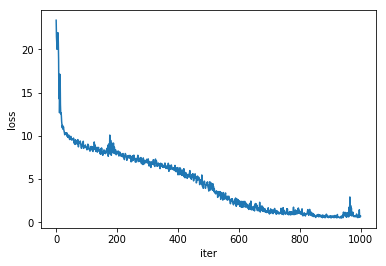

In [187]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("loss")
plt.show()

**Evaluate performance**

Evaluation...


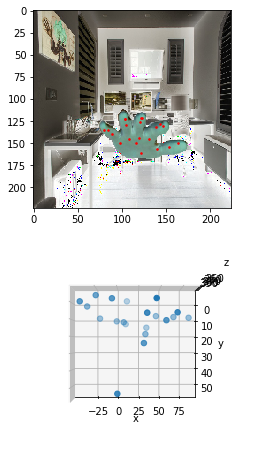

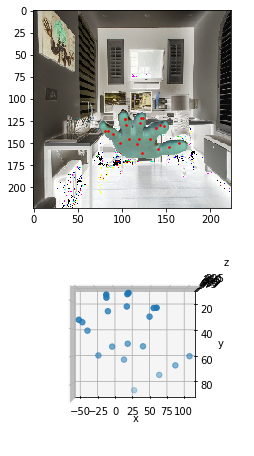

In [189]:
def makePosList(h_pred, l_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(h_pred.view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = l_pred[0].data.numpy()
    p3d_x = p3d_x[p2d_y, p2d_x]

    p3d_y = l_pred[1].data.numpy()
    p3d_y = p3d_y[p2d_y, p2d_x]

    p3d_z = l_pred[2].data.numpy()
    p3d_z = p3d_z[p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d

print("Evaluation...")
eval_loss = 0
eval_iter = 0
for idx, batch in enumerate(loader_train):
    eval_iter = idx
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    y_pred = model(image)
    h_pred = modelHeatmap(y_pred)
    l_pred = modelLocmap(y_pred)
    #print("output shape: {}".format(y_pred.shape))
    # use heatmap loss defined in VNect
    #loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
    
    #eval_loss = eval_loss + loss
    
    if idx == 0:
        # show some images
        p2d, p3d = makePosList(h_pred[0], l_pred[0])
        show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
        show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])
        break

#eval_iter = eval_iter + 1
#print("Eval Loss: {}".format(eval_loss / eval_iter))

**Save and load trained models**

In [191]:
#torch.save(model, 'model.pt')
#model = torch.load('model.pt')

# save/load only the model parameters(prefered solution)
torch.save(model.state_dict(), 'model_param.pt')
#model.load_state_dict(torch.load('model_param.pt'))